В этой тетрадке я напишу свои мысли по поводу фильтрации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as prep

from sklearn.preprocessing import MinMaxScaler

Вот так выглядит двумерное распределение дебита от времени измерения. Но время замера протянуто впереёд, полную картину дадут исходные данные

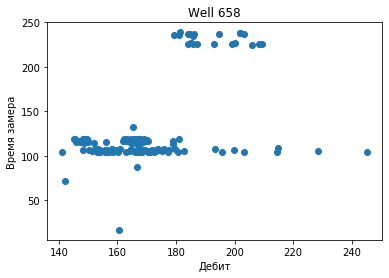

153


In [11]:
well_name = 658
well = well_name
calculated_data = prep.load_calculated_data_from_csv(f'data/{well_name}/restore_/{well_name}_restore_1.csv')
input_data = pd.read_csv(f'data/{well_name}/restore_input_/{well_name}_restore_input.csv',
                         parse_dates=True, index_col = 'Время')
all_data = input_data.join(calculated_data, how = 'outer')
all_data.to_csv(f'data/{well_name}/restore_/{well_name}_calc_and_input.csv')

plt.scatter(all_data['Объемный дебит жидкости (СУ)'], all_data['Время замера фактическое (СУ)'])
plt.xlabel('Дебит')
plt.ylabel('Время замера')
plt.title(f'Well {well_name}')
plt.show()
print(len(all_data['Объемный дебит жидкости (СУ)']))

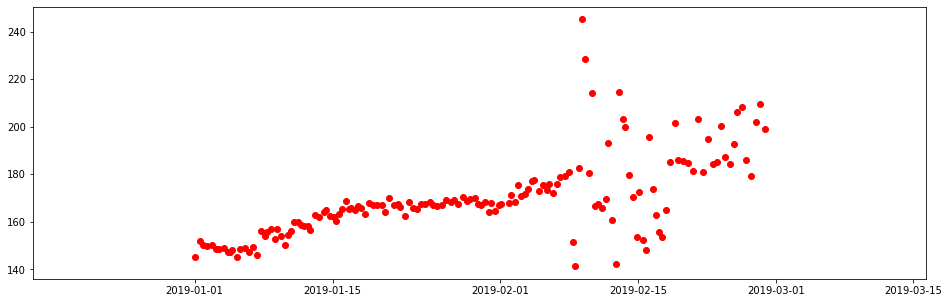

In [10]:
pfig = plt.figure(figsize=(16,5))
plt.scatter(all_data['Объемный дебит жидкости (СУ)'].index,
            all_data['Объемный дебит жидкости (СУ)'].values.reshape((-1, 1)), c='red',
            label='not filtered_data')

А вот так выглядят настоящие данные

In [3]:
cs_d = pd.read_csv(f'data/{well_name}/init_edit/{well_name}_first_edit.csv')

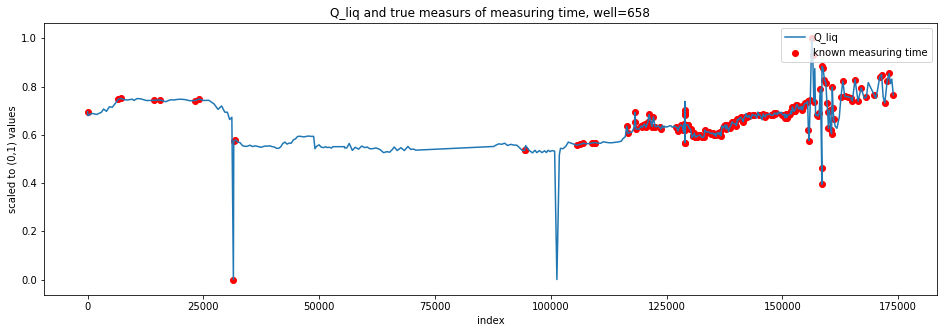

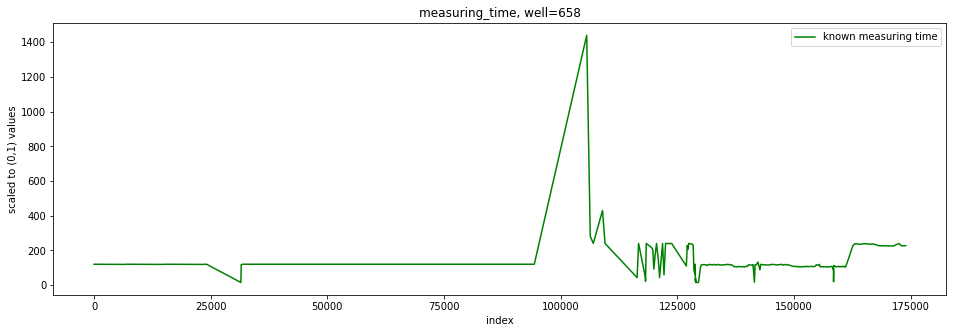

Известн замеров: 185/911


In [4]:
fig = plt.figure(figsize=(16,5))
sc = MinMaxScaler()
# строим дебит
plt.plot(cs_d['Объемный дебит жидкости'].dropna().index,
         sc.fit_transform(cs_d['Объемный дебит жидкости'].dropna().values.reshape((-1, 1))),
           label='Q_liq')

sc_data  = cs_d['Время замера фактическое'].dropna().to_frame().join(cs_d['Объемный дебит жидкости'].dropna().to_frame(),
                                                                     how='inner')
# строим флажки там где известно время замера
plt.scatter(sc_data['Объемный дебит жидкости'].dropna().index,
            sc.transform(sc_data['Объемный дебит жидкости'].dropna().values.reshape((-1, 1))), c='red',
           label='known measuring time')

plt.legend(loc='upper right')
plt.title(f'Q_liq and true measurs of measuring time, well={well}')
plt.ylabel('scaled to (0,1) values')
plt.xlabel('index')
plt.show()

pfig = plt.figure(figsize=(16,5))
plt.plot(sc_data.dropna().index,
            sc_data['Время замера фактическое'].dropna().values.reshape((-1, 1)), c='green',
            label='known measuring time')
plt.title(f'measuring_time, well={well}')
plt.ylabel('scaled to (0,1) values')
plt.xlabel('index')
plt.legend(loc='upper right')
plt.show()

print(f'Известн замеров: {sc_data["Объемный дебит жидкости"].dropna().shape[0]}/{cs_d["Объемный дебит жидкости"].dropna().shape[0]}')

Видно, что замеры в области пика не производились, это наводит на мысль, что делать выводы о некорректности замеров только лишь по времени замера - некорректно, из-за отсутствия адекватного набора данных

Будем определять аномалии как отклонение от среднего

In [5]:
m = all_data['Объемный дебит жидкости (СУ)'].mean()
sigma =  all_data['Объемный дебит жидкости (СУ)'].values.std()

In [6]:
all_data_f = all_data.copy()
all_data_f = all_data_f[all_data_f['Объемный дебит жидкости (СУ)'] <= m + 3 * sigma]
all_data_f = all_data_f[all_data_f['Объемный дебит жидкости (СУ)'] >= m - 2 * sigma]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


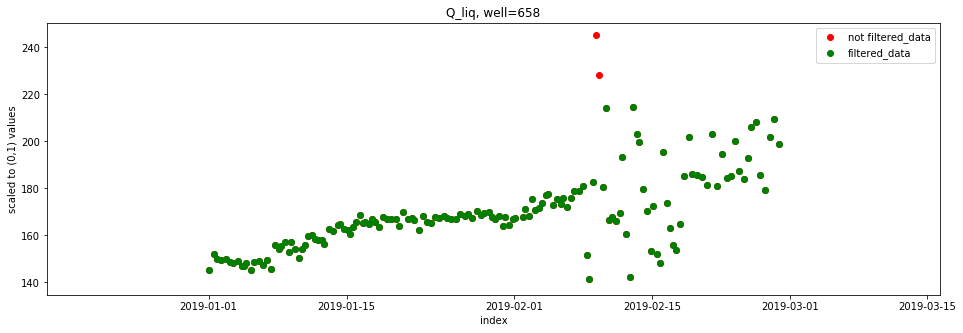

In [7]:
pfig = plt.figure(figsize=(16,5))
plt.scatter(all_data['Объемный дебит жидкости (СУ)'].dropna().index,
            all_data['Объемный дебит жидкости (СУ)'].dropna().values.reshape((-1, 1)), c='red',
            label='not filtered_data')
plt.scatter(all_data_f['Объемный дебит жидкости (СУ)'].dropna().index,
            all_data_f['Объемный дебит жидкости (СУ)'].dropna().values.reshape((-1, 1)), c='green',
            label='filtered_data')
plt.title(f'Q_liq, well={well}')
plt.ylabel('scaled to (0,1) values')
plt.xlabel('index')
plt.legend(loc='upper right')
plt.show()